# Fraudulent activities


**Goal**

- E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etc.

- Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.

- The goal of this project is to build a machine learning model that predicts the probability that the ﬁrst transaction of a new user is fraudulent.

**Description**

Company here is an e-commerce site that sells hand-made clothes.

We have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. 

We only have information about the user ﬁrst transaction on the site and based on that we have to make your classiﬁcation ("fraud/no fraud").

These are the tasks we are asked to do:

- For each user, determine her country based on the numeric IP address.
- Build a model to predict whether an activity is fraudulent or not. 
- Explain how diﬀerent assumptions about the cost of false positives vs false negatives would impact the model.


## Import libraries and data

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV
from sklearn.linear_model import Ridge

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,StackingClassifier,BaggingRegressor
import time
import datetime
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from xgboost import XGBClassifier

In [5]:
! pip install pendulum

In [3]:
dataset=pd.read_csv('Fraud_Data.csv')
dataset.shape

(151112, 11)

In [4]:
ip_data=pd.read_csv('IpAddress_to_Country.csv')
ip_data.shape

(138846, 3)

## EDA

In [5]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
# Basic stats
data_desc = dataset.describe(include='all')
print(data_desc)
print(dataset.shape)

              user_id          signup_time        purchase_time  \
count   151112.000000               151112               151112   
unique            NaN               151112               150679   
top               NaN  2015-02-01 17:18:27  2015-09-10 09:04:53   
freq              NaN                    1                    3   
mean    200171.040970                  NaN                  NaN   
std     115369.285024                  NaN                  NaN   
min          2.000000                  NaN                  NaN   
25%     100642.500000                  NaN                  NaN   
50%     199958.000000                  NaN                  NaN   
75%     300054.000000                  NaN                  NaN   
max     400000.000000                  NaN                  NaN   

        purchase_value      device_id  source browser     sex            age  \
count    151112.000000         151112  151112  151112  151112  151112.000000   
unique             NaN         1379

*No missing values*

In [9]:
dataset['class'].value_counts(normalize=True)

0    0.906354
1    0.093646
Name: class, dtype: float64

*9,3% of transactions are fraudulent*

In [7]:
# Basic stats
data_ip = ip_data.describe(include='all')
print(data_ip)
print(ip_data.shape)

        lower_bound_ip_address  upper_bound_ip_address        country
count             1.388460e+05            1.388460e+05         138846
unique                     NaN                     NaN            235
top                        NaN                     NaN  United States
freq                       NaN                     NaN          46868
mean              2.724532e+09            2.724557e+09            NaN
std               8.975215e+08            8.974979e+08            NaN
min               1.677722e+07            1.677747e+07            NaN
25%               1.919930e+09            1.920008e+09            NaN
50%               3.230887e+09            3.230888e+09            NaN
75%               3.350465e+09            3.350466e+09            NaN
max               3.758096e+09            3.758096e+09            NaN
(138846, 3)


In [8]:
ip_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Data Engineering

In [11]:
## Add country column to the user dataset
start_time = time.time()
countries = []
for i in tqdm(range(len(dataset))):
    ip_address = dataset['ip_address'][i]
        
    tmp = ip_data[(ip_data['lower_bound_ip_address'] <= ip_address) &
                          (ip_data['upper_bound_ip_address'] >= ip_address)] 
    
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('Unkown')
        
dataset['country'] = countries
print("--- %s seconds ---" % (time.time() - start_time)) 

100%|██████████| 151112/151112 [02:26<00:00, 1029.12it/s]

--- 146.83876585960388 seconds ---


In [12]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unkown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [103]:
#% of converted by country;
dataset.country.value_counts()

United States                           58049
NA                                      21966
China                                   12038
Japan                                    7306
United Kingdom                           4490
Korea Republic of                        4162
Germany                                  3646
France                                   3161
Canada                                   2975
Brazil                                   2961
Italy                                    1944
Australia                                1844
Netherlands                              1680
Russian Federation                       1616
India                                    1310
Taiwan; Republic of China (ROC)          1237
Mexico                                   1121
Sweden                                   1090
Spain                                    1027
South Africa                              838
Switzerland                               785
Poland                            

In [18]:
country=dataset.country.value_counts(normalize=True).index
country[0:20]

Index(['United States', 'Unkown', 'China', 'Japan', 'United Kingdom',
       'Korea Republic of', 'Germany', 'France', 'Canada', 'Brazil', 'Italy',
       'Australia', 'Netherlands', 'Russian Federation', 'India',
       'Taiwan; Republic of China (ROC)', 'Mexico', 'Sweden', 'Spain',
       'South Africa'],
      dtype='object')

In [15]:
#% of converted by country;
dataset.loc[dataset["class"]==1].country.value_counts(normalize=True)

United States     0.392269
Unkown            0.133065
China             0.073705
Japan             0.050526
United Kingdom    0.033708
                    ...   
Mauritius         0.000071
Nicaragua         0.000071
Senegal           0.000071
Malawi            0.000071
Guatemala         0.000071
Name: country, Length: 110, dtype: float64

In [276]:
taille_country=country[0:40]
dataset['country2']=dataset['country']
dataset['country2']=dataset.country2.apply(lambda x:
                       "Others" if x not in taille_country
                                    else x)

In [277]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,country2,day_of_week,month,week_of_month,tdelta,day_of_week_sign,month_sign,week_of_month_sign
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,Japan,sat,April,w3,4506682.0,tue,February,w5
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,United States,mon,June,w2,17944.0,sun,June,w1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,thu,January,w1,1.0,thu,January,w1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unkown,Unkown,mon,May,w2,492085.0,tue,April,w5
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,United States,wed,September,w2,4361461.0,tue,July,w4


## time management

In [278]:
date_sign_up=pd.to_datetime(dataset.signup_time)
date_purchase=pd.to_datetime(dataset.purchase_time)

In [279]:
def get_weekday(x):
    t1=x.weekday()
    if t1==0:
        res='mon'
    elif t1==1:
        res='tue'
    elif t1==2:
        res='wed'    
    elif t1==3:
        res='thu' 
    elif t1==4:
        res='fri' 
    elif t1==5:
        res='sat'
    elif t1==6:
        res='sun'  
    return res       
        

In [280]:
dataset['day_of_week']=date_purchase

In [281]:
dataset['day_of_week']=dataset.day_of_week.apply(lambda x:get_weekday(x))

In [282]:
dataset['day_of_week_sign']=date_sign_up

In [283]:
dataset['day_of_week_sign']=dataset.day_of_week_sign.apply(lambda x:get_weekday(x))

In [284]:
dataset['month']=date_purchase
dataset['month']=dataset['month'].dt.month_name()

In [285]:
dataset['month_sign']=date_sign_up
dataset['month_sign']=dataset['month_sign'].dt.month_name()

In [286]:
import pendulum


In [287]:
def get_week_of_month(w):
    d=w.date().isoformat()
    dt = pendulum.parse(d)
    return str(dt.week_of_month)
    

In [288]:
dataset['week_of_month']=date_purchase

In [289]:
dataset['week_of_month']=dataset.week_of_month.apply(lambda x:'w'+get_week_of_month(x))

In [290]:
dataset['week_of_month_sign']=date_sign_up

In [291]:
dataset['week_of_month_sign']=dataset.week_of_month_sign.apply(lambda x:'w'+get_week_of_month(x))

In [380]:
#Time difference between sign-up time and purchase time
tdelta=(date_purchase-date_sign_up).dt.total_seconds()/86400

In [381]:
60*60*24

86400

In [382]:
dataset['tdelta']=tdelta

In [383]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,country2,day_of_week,month,week_of_month,tdelta,day_of_week_sign,month_sign,week_of_month_sign
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,Japan,sat,April,w3,52.160671,tue,February,w5
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,United States,mon,June,w2,0.207685,sun,June,w1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,United States,thu,January,w1,0.000012,thu,January,w1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unkown,Unkown,mon,May,w2,5.695428,tue,April,w5
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,United States,wed,September,w2,50.479873,tue,July,w4


*If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)*

In [384]:
device_num = dataset[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'nb_id_used'})
device_num.head()

,device_id,nb_id_used
0,AAALBGNHHVMKG,1
1,AAAWIHVCQELTP,1
2,AAAXJHWCLISKY,1
3,AAAXXOZJRZRAO,11
4,AABFGRPBQHWFQ,1


In [385]:
data2 = dataset.merge(device_num, how='left', on='device_id')

In [386]:
data2.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,country,country2,day_of_week,month,week_of_month,tdelta,day_of_week_sign,month_sign,week_of_month_sign,nb_id_used
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Japan,Japan,sat,April,w3,52.160671,tue,February,w5,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,United States,United States,mon,June,w2,0.207685,sun,June,w1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,United States,United States,thu,January,w1,0.000012,thu,January,w1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,Unkown,Unkown,mon,May,w2,5.695428,tue,April,w5,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,United States,United States,wed,September,w2,50.479873,tue,July,w4,1


In [387]:
data2['hour_of_day']=date_purchase

In [388]:
data2['hour_of_day']=data2['hour_of_day'].dt.hour

In [389]:
data2['hour_of_day_sign']=date_sign_up

In [390]:
data2['hour_of_day_sign']=data2['hour_of_day_sign'].dt.hour

In [391]:
datafi=data2.drop(['user_id', 'signup_time','purchase_time','device_id','ip_address','country'], axis=1)

In [392]:
datafi.head()

,purchase_value,source,browser,sex,age,class,country2,day_of_week,month,week_of_month,tdelta,day_of_week_sign,month_sign,week_of_month_sign,nb_id_used,hour_of_day,hour_of_day_sign
0,34,SEO,Chrome,M,39,0,Japan,sat,April,w3,52.160671,tue,February,w5,1,2,22
1,16,Ads,Chrome,F,53,0,United States,mon,June,w2,0.207685,sun,June,w1,1,1,20
2,15,SEO,Opera,M,53,1,United States,thu,January,w1,0.000012,thu,January,w1,12,18,18
3,44,SEO,Safari,M,41,0,Unkown,mon,May,w2,5.695428,tue,April,w5,1,13,21
4,39,Ads,Safari,M,45,0,United States,wed,September,w2,50.479873,tue,July,w4,1,18,7


In [393]:
datafi.isna().values.any()

False

## Modelization


In [607]:
col=datafi.columns
col

Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'class',
       'country2', 'day_of_week', 'month', 'week_of_month', 'tdelta',
       'day_of_week_sign', 'month_sign', 'week_of_month_sign', 'nb_id_used',
       'hour_of_day', 'hour_of_day_sign'],
      dtype='object')

In [608]:
col=col.drop(['class','browser','age','sex','source','month','week_of_month_sign','week_of_month'])
col

Index(['purchase_value', 'country2', 'day_of_week', 'tdelta',
       'day_of_week_sign', 'month_sign', 'nb_id_used', 'hour_of_day',
       'hour_of_day_sign'],
      dtype='object')

In [609]:
features_list = col
target_variable = 'class'


In [610]:
X = datafi.loc[:, features_list]
Y = datafi.loc[:, target_variable]

print('Variables explicatives : ', X.columns)
print()

Variables explicatives :  Index(['purchase_value', 'country2', 'day_of_week', 'tdelta',
       'day_of_week_sign', 'month_sign', 'nb_id_used', 'hour_of_day',
       'hour_of_day_sign'],
      dtype='object')



In [611]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features.append(i)
    numeric_indices.append(idx)
  else :
    categorical_features.append(i)
    categorical_indices.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)


Found numeric features  ['purchase_value', 'tdelta', 'nb_id_used', 'hour_of_day', 'hour_of_day_sign']  at positions  [0, 3, 6, 7, 8]
Found categorical features  ['country2', 'day_of_week', 'day_of_week_sign', 'month_sign']  at positions  [1, 2, 4, 5]


In [612]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42,stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [613]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[31 'France' 'tue' 2.2188773148148146 'sun' 'March' 1 12 7]
 [63 'Viet Nam' 'tue' 74.0587962962963 'fri' 'February' 1 13 11]
 [30 'Australia' 'wed' 67.2835300925926 'sat' 'April' 1 16 10]
 [42 'United States' 'wed' 91.49304398148149 'wed' 'April' 1 13 1]
 [34 'United States' 'sun' 78.4929050925926 'fri' 'June' 1 5 17]]
[[18 'Japan' 'mon' 70.58664351851851 'sun' 'June' 1 3 13]
 [59 'France' 'sun' 110.36195601851851 'tue' 'June' 1 15 7]]

[0 0 0 0 0]
[0 0]


In [614]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")


# Normalization
numeric_transformer = StandardScaler()
    
# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]    )

X_train = featureencoder.fit_transform(X_train)

print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
  (0, 12)	1.0
  (0, 44)	1.0
  (0, 48)	1.0
  (0, 57)	1.0
  (0, 59)	-0.32591940800140107
  (0, 60)	-1.5194668184591007
  (0, 61)	-0.26200651533242125
  (0, 62)	0.06843999279835387
  (0, 63)	-0.6479144684240955
  (1, 39)	1.0
  (1, 44)	1.0
  (1, 53)	1.0
  (1, 59)	1.4186993806756334
  (1, 60)	0.4649858108552383
  (1, 61)	-0.26200651533242125
  (1, 62)	0.21325664726049628
  (1, 63)	-0.06952312779718355
  (2, 0)	1.0
  (2, 45)	1.0
  (2, 47)	1.0
  (2, 59)	-0.3804387451475584
  (2, 60)	0.277830883304301
  (2, 61)	-0.26200651533242125
  (2, 62)	0.6477066106469235
  (2, 63)	-0.21412096295391156
  (3, 37)	1.0
  (3, 45)	1.0
  (3, 51)	1.0
  (3, 59)	0.27379330060632956
  (3, 60)	0.9465765357543232
  (3, 61)	-0.26200651533242125
  (3, 62)	0.21325664726049628
  (3, 63)	-1.5155014793644634
  (4, 37)	1.0
  (4, 42)	1.0
  (4, 56)	1.0
  (4, 59)	-0.16236139656292908
  (4, 60)	0.5874703429124677
  (4, 61)	-0.26200651533242125
  (4, 6

In [615]:
classifier = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=2))

classifier.fit(X_train, Y_train)
print("...Done.")



...Done.


In [616]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [617]:
print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
  (0, 19)	1.0
  (0, 40)	1.0
  (0, 48)	1.0
  (0, 56)	1.0
  (0, 59)	-1.0346707909014463
  (0, 60)	0.3690736382507794
  (0, 61)	-0.26200651533242125
  (0, 62)	-1.2349098973609278
  (0, 63)	0.21967254251627244
  (1, 12)	1.0
  (1, 42)	1.0
  (1, 50)	1.0
  (1, 56)	1.0
  (1, 59)	1.2006220320910042
  (1, 60)	1.4677973644394353
  (1, 61)	-0.26200651533242125
  (1, 62)	0.502889956184781
  (1, 63)	-0.6479144684240955
  (2, 3)	1.0
  (2, 45)	1.0
  (2, 49)	1.0
  (2, 58)	1.0
  (2, 59)	-0.980151453755289
  (2, 60)	-1.2192844882123206
  (2, 61)	-0.26200651533242125
  (2, 62)	1.0821565740333507
  (2, 63)	0.7980638831431844
  (3, 37)	1.0
  (3, 40)	1.0
  (3, 50)	1.0
  (3, 57)	1.0
  (3, 59)	-0.5439967565860303
  (3, 60)	-1.4001874156056544
  (3, 61)	-0.26200651533242125
  (3, 62)	0.502889956184781
  (3, 63)	-1.2263058090510075
  (4, 24)	1.0
  (4, 53)	1.0
  (4, 59)	-0.980151453755289
  (4, 60)	-0.21408275548323738
  (4, 61)	-0.2620

In [618]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [619]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7011318446007954
f1-score on test set :  0.6954718285516764


CONFUSION MATRIX ON TEST SET


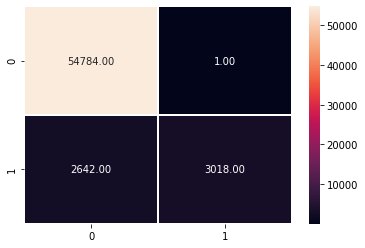

In [620]:
print("CONFUSION MATRIX ON TEST SET")
cm2=confusion_matrix(Y_test,Y_test_pred)
sns.heatmap(cm2, annot=True, annot_kws={"size": 10}, fmt=".2f", linewidths=1)

In [621]:
TN=cm2[0,0]
FN=cm2[1,0]
FP=cm2[0,1]
TP=cm2[1,1]

In [622]:
print('true negatives: the model identified {} transactions as "legitimate" and it is correct'.format(TN))
print('false negatives: the model identified {} transactions as "legitimate" but it is actually a fraud '.format(FN))
print('false positives: the model identified {} transactions as "fraud" but it is not one '.format(FP))
print('true positives: the model identified {} transactions as "fraud" and it is one '.format(TP))

true negatives: the model identified 54784 transactions as "legitimate" and it is correct
false negatives: the model identified 2642 transactions as "legitimate" but it is actually a fraud 
false positives: the model identified 1 transactions as "fraud" but it is not one 
true positives: the model identified 3018 transactions as "fraud" and it is one 


## Evaluation in terms of costs

To evaluate a model’s performance in terms of costs, I first calculated the sum of all costs resulting from the predictions based on whether the model predicted a False Positive, False Negative, True Positive or True Negative and the costs associated with each case.

In [623]:
mean_purchase=36  # here 36 $ is the mean value of a purchase
admin_cost=0.1  #administraion cost  
cost_TN=0
cost_TP=admin_cost
cost_FN=mean_purchase
cost_FP=admin_cost

costs=TN*cost_TN+FN*cost_FN+TP*cost_TP+FP*cost_FP
costs

95413.90000000001

I then calculated the sum of the costs that would occur if all cases were predicted negative (“cost_max”), and define the cost savings as the fraction by which the actual predictions reduce the costs.

In [624]:
percent_fraud=0.09
costs_max=(TN+TP+FN+FP)*percent_fraud*mean_purchase
costs_max

195841.80000000002

In [625]:
cost_savings=1-(costs/costs_max)
print("cost savings:",cost_savings)

cost savings: 0.5128011486822528
